In [1]:
import pandas as pd
import ast
from html import unescape
import matplotlib.pyplot as plt

Se carga el archivo previamente procesado en ETL_EDA_inicial

In [8]:
df_games=pd.read_csv('processed_data/steam_games.csv')
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140.0,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290.0,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,0.0,767400.0,彼岸领域
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,0.0,773570.0,NaN


<h3>Consideramos muy relevante para nuestros analisis la columna genres de esta tabla, por lo que vamos a analizarla en profundidad<h3\>

Se observa que el tipo de dato de la columna genres (asi como la columna tags y specs) se encuentran en formato string.

In [7]:
df_games.dtypes

publisher        object
genres           object
app_name         object
title            object
url              object
release_date     object
tags             object
reviews_url      object
specs            object
price            object
early_access    float64
id              float64
developer        object
dtype: object

In [9]:
#Se corrigen problemas de codificacion en la columna genres (el caracter '&' aparece como '&amp;')
df_games['genres'] = df_games['genres'].apply(lambda x: unescape(x) if isinstance(x, str) else x)


In [10]:
#Se normaliza las columnas genres, tags y specs convirtiendo su contenido (actualmente en formato string) en una lista
df_games['genres'] = df_games['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df_games['tags'] = df_games['tags'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df_games['specs'] = df_games['specs'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

Se crea una lista de generos unicos para poder observarlos mejor

In [11]:
#Se crea la lista de generos unicos
unique_genres = df_games['genres'].explode().unique()
unique_genres

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'Free to Play', 'RPG', 'Sports', 'Adventure', nan, 'Racing',
       'Early Access', 'Massively Multiplayer', 'Animation & Modeling',
       'Video Production', 'Utilities', 'Web Publishing', 'Education',
       'Software Training', 'Design & Illustration', 'Audio Production',
       'Photo Editing', 'Accounting'], dtype=object)

Se observa que mas de 3000 registros tienen vacio el campo 'genres'. para no desecharlos, se opta por la idea de crear una lista de generos unicos basada en los demas titulos y buscar para cada registro si existe algun genero de la lista en el campo 'tags'. de esta manera se puede completar el campo 'genres' de una manera consistente.

In [12]:
df_games['genres'].isnull().sum()

3283

In [13]:
#Se identifican los registros con 'genres' vacio y, si hay coincidencia entre sus tags y algun genenro unico, se aplican esos tags en 'genres'
for index, row in df_games[df_games['genres'].isnull()].iterrows():
    tags = row['tags']
    if isinstance(tags, list):
        common_genres = set(tags).intersection(unique_genres)
        if common_genres:
            df_games.at[index, 'genres'] = list(common_genres)

Se confrima que la cantidad de nulos en el campo genres se redujo enormemente. optamos por no eliminar esos registros ya que estariamos eliminando mucha informacion de otros campos. mas adelante, si es necesario para algun analisis puntual se eliminaran los registros que tengan el campo genres vacio.

In [14]:
df_games.isnull().sum()

publisher       8071
genres           926
app_name           2
title           2050
url                0
release_date    2067
tags             163
reviews_url        2
specs            670
price           1377
early_access       0
id                 2
developer       3299
dtype: int64

In [15]:
#Se eliminan los registros con id vacios ya que son pocos (2), lo que lo hace irrelevante para nuestro enfoque
df_games = df_games.dropna(subset=['id'])
#Se elimina el registros con app_name vacio ya que es irrelevante para nuestro enfoque
df_games = df_games.dropna(subset=['app_name'])

Se realiza un grafico de barras para visualizar estadisticamente la relevancia de cada genero.

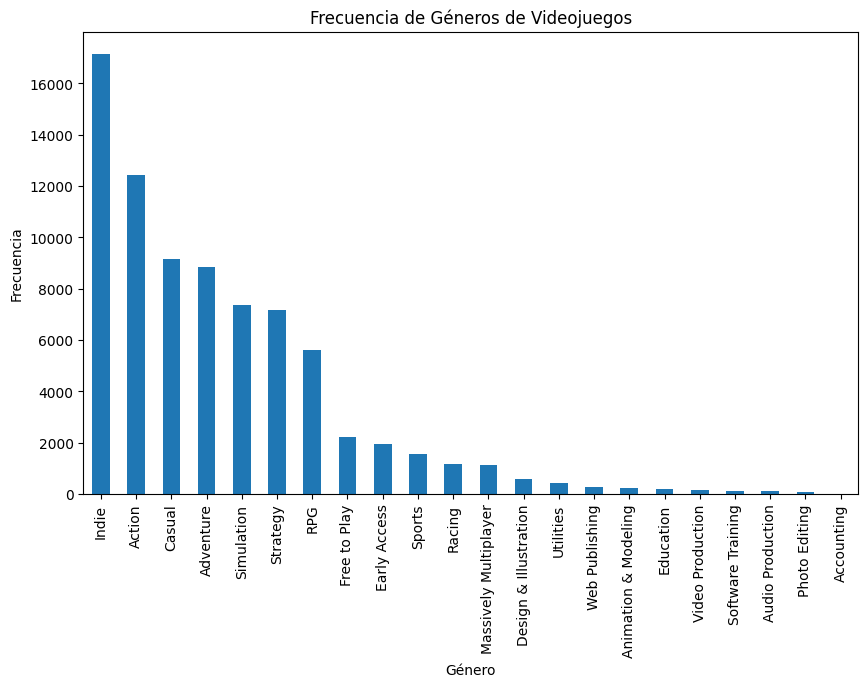

In [16]:

frecuencia_generos = df_games['genres'].explode().value_counts()

frecuencia_generos.plot(kind='bar', figsize=(10, 6))
plt.title('Frecuencia de Géneros de Videojuegos')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()

Se observa que el campo 'release_date' contiene fechas en diferentes formatos. Normalizamos el formato y extraemos solo el año de cada fecha, ya que mes y dia no son informacion relevante para nuestros analisis. se crea una nueva columna llamada 'release_year'

In [17]:
#Se crea una funcion para extraer el año de fechas y dejar los no fechas sin cambios
def get_year(item):
    try:
        #Se intenta convertir la fecha a un objeto de fecha de pandas
        date = pd.to_datetime(item)
        return date.year
    except (ValueError, TypeError):
       #Si hay un error, se intenta extraer el año de otros formatos
        if isinstance(item, str):
            #Se busca un año de cuatro dígitos en el formato 'XXXX'
            anio_encontrado = [int(s) for s in item.split() if s.isdigit() and len(s) == 4]
            if anio_encontrado:
                return anio_encontrado[0]

    #Si no se puede extraer ningun año, devuelve NaN (se utiliza pd.NaT para un correcto manejo de los valores nulos. no se obtuvo el resultado esperado utilizando np.nan).
    return pd.NaT

# Aplicar la función a la columna 'release_date' creando una nueva 'release_year'
df_games['release_year']=df_games['release_date'].apply(get_year)



C:\Users\PC\AppData\Local\Temp\ipykernel_18068\3481045313.py:5: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(item)


Eliminamos las columnas que no seran necesarias en ninguna parte de nuestro proyecto
<img src="assets/analisis_campos_necesarios_games.png">


In [18]:
#Se eliminan columnas que no son relevantes para nuestro objetivo
df_games.drop(columns=['publisher','title','url','reviews_url','price','early_access', 'release_date'],inplace=True)

In [19]:
#Se guarda el dataset en formato parquet
df_games.to_parquet('processed_data/games.parquet',index=False)